# TRABAJO SEMANAL 8

> ## Alumno: Fabrizio Hermosa
> ## Materia: Teoría de los circuitos II
> ## Curso: R4001

## <u> Consignas y desarrollo </u>  ##

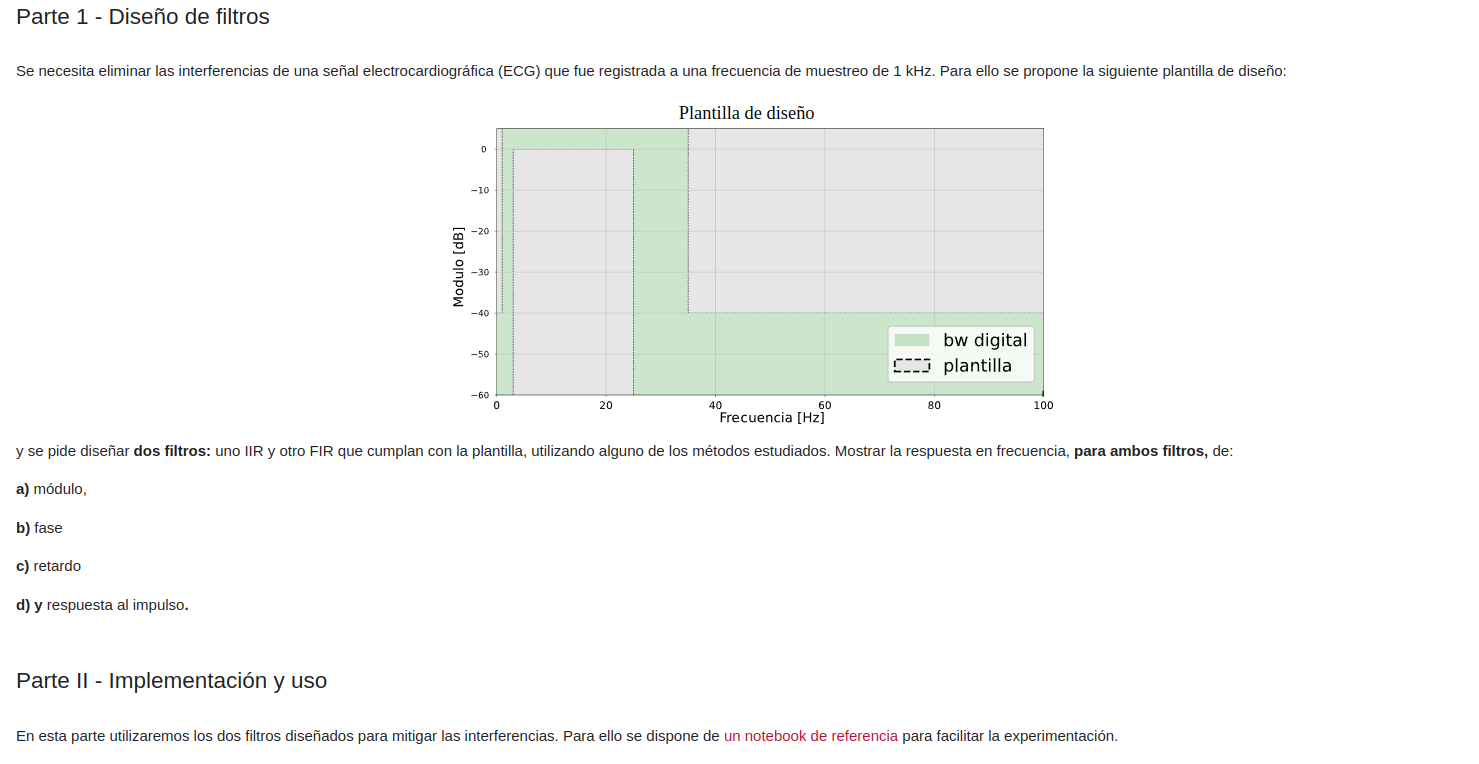


## <u> Parte 1: Diseño de filtros  </u>  ##

### Filtro IIR ###

In [1]:
#Importo librerias
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Para fijar el estilo de gráficos en el notebook
fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100
fig_font_size = 16

plt.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
plt.rcParams['figure.dpi'] = (fig_dpi)
plt.rcParams.update({'font.size':fig_font_size})

In [3]:
#Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1e3
nyq_frec = fs/2

In [4]:
#Plantilla
ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

ripple = 0.5
atenuacion = 40

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

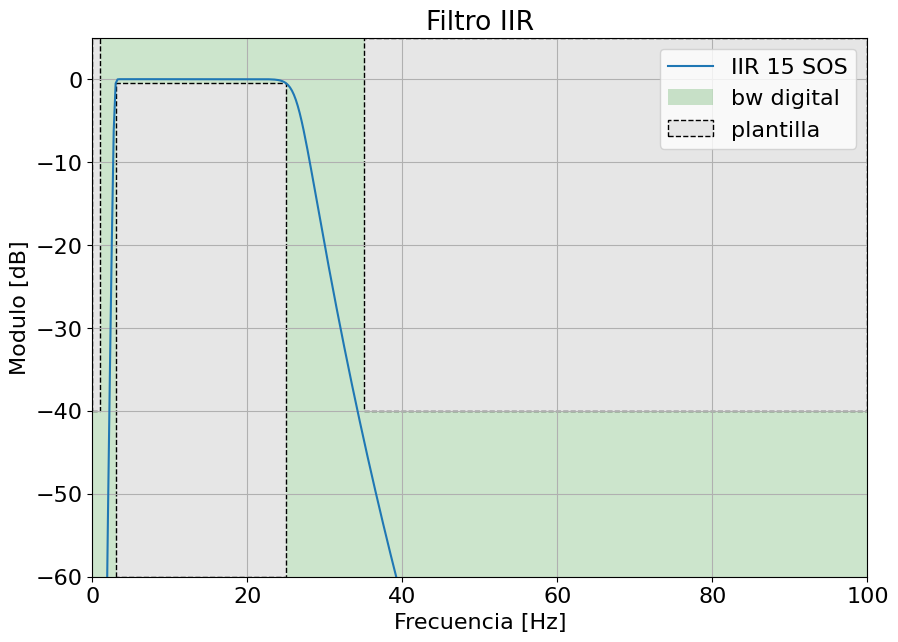

In [5]:
iir = sig.iirdesign(wp=[wp1,wp2], ws=[ws1,ws2], gpass=ripple, gstop=atenuacion, analog=False, ftype='butter', output='sos', fs=1e3)

w, h = sig.sosfreqz(iir, worN = 2000, fs = fs)

#Modulo
plt.plot(w, 20*np.log10(abs(h)), label='IIR {:d} SOS'.format(iir.shape[0]))
plt.title('Filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5])
plot_plantilla(filter_type='bandpass', fpass=[wp1, wp2], ripple=ripple, fstop=[ws1, ws2], attenuation=atenuacion, fs=fs)
axes_hdl = plt.gca()
axes_hdl.legend()

(0.0, 100.0, -6.283185307179586, 6.283185307179586)

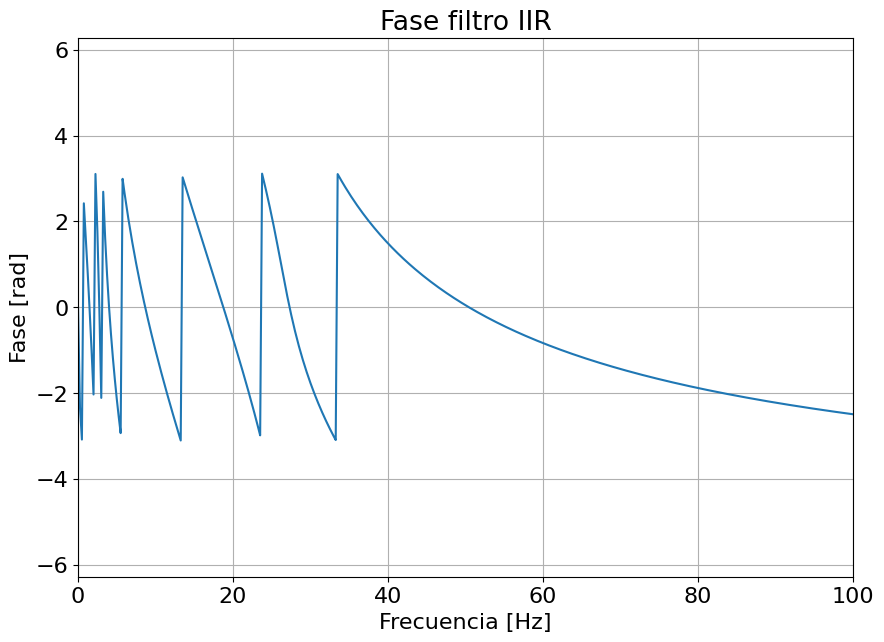

In [6]:
#Fase
fase = np.angle(h)
plt.plot(w, fase)

plt.title('Fase filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, 100, -2*np.pi, 2*np.pi])


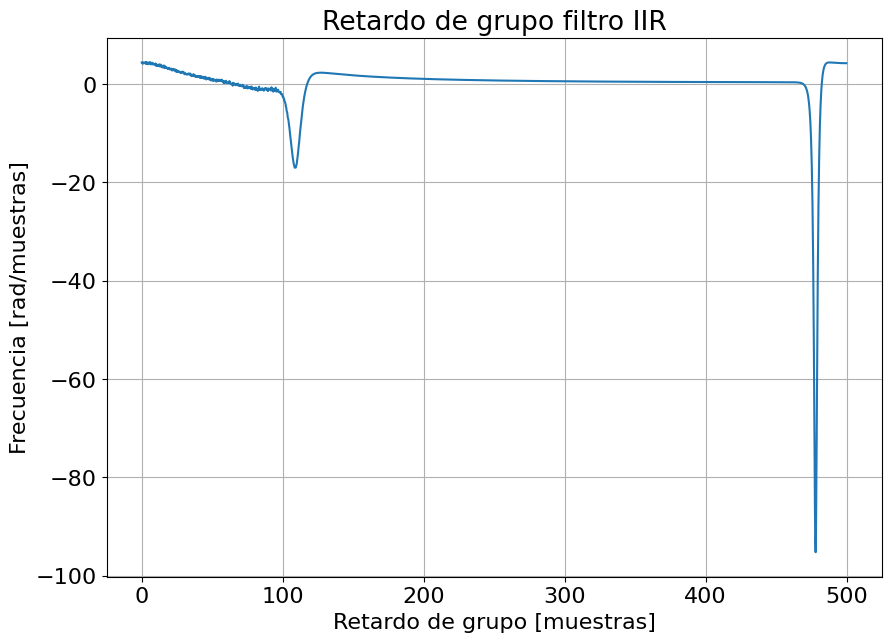

In [7]:
#Retardo de grupo
bn, an = sig.sos2tf(iir)
w, gd = sig.group_delay((bn, an), w=2000, whole=False, fs=fs)

plt.plot(w, gd)
plt.title('Retardo de grupo filtro IIR')
plt.xlabel('Retardo de grupo [muestras]')
plt.ylabel('Frecuencia [rad/muestras]')
plt.grid()

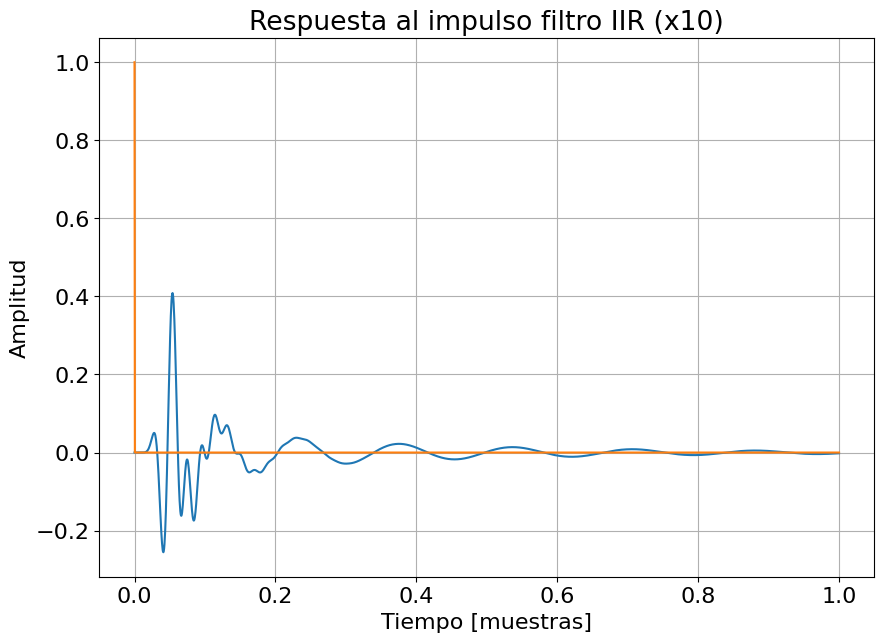

In [8]:
#Respuesta al impulso

imp = sig.unit_impulse(2000)
response = sig.sosfilt(iir, imp)

plt.plot(np.linspace(0, 1, 2000), response * 10)
plt.plot(np.linspace(0, 1, 2000), imp)

plt.title('Respuesta al impulso filtro IIR (x10)')
plt.xlabel('Tiempo [muestras]')
plt.ylabel('Amplitud')
plt.grid()

### Filtro FIR ###

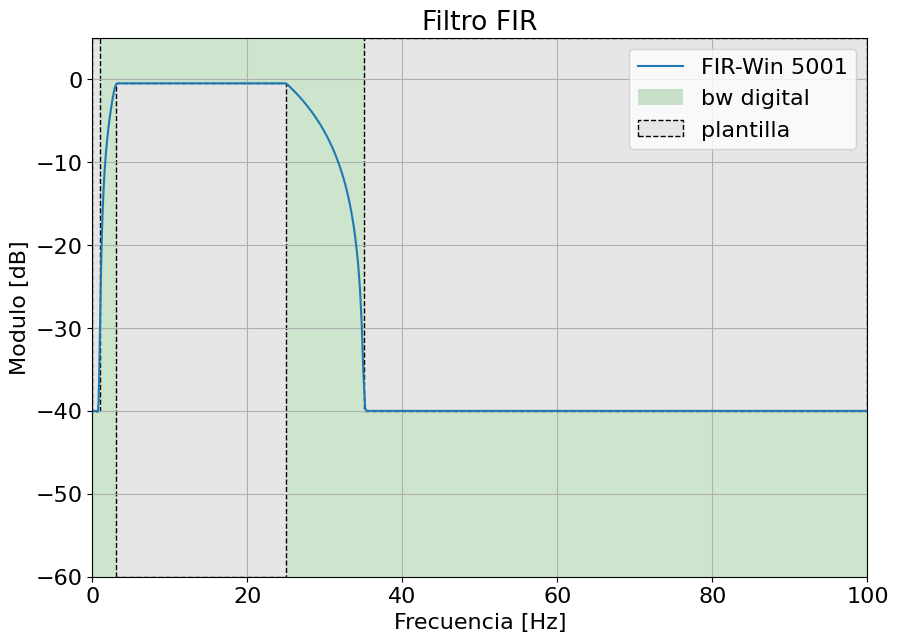

In [9]:
num_coef = 5001

num_win = sig.firwin2(num_coef, frecs, gains, window='hamming')

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5])
plot_plantilla(filter_type='bandpass', fpass=[wp1, wp2], ripple=ripple, fstop=[ws1, ws2], attenuation=atenuacion, fs=fs)
axes_hdl = plt.gca()
axes_hdl.legend()

(0.0, 500.0, -6.283185307179586, 6.283185307179586)

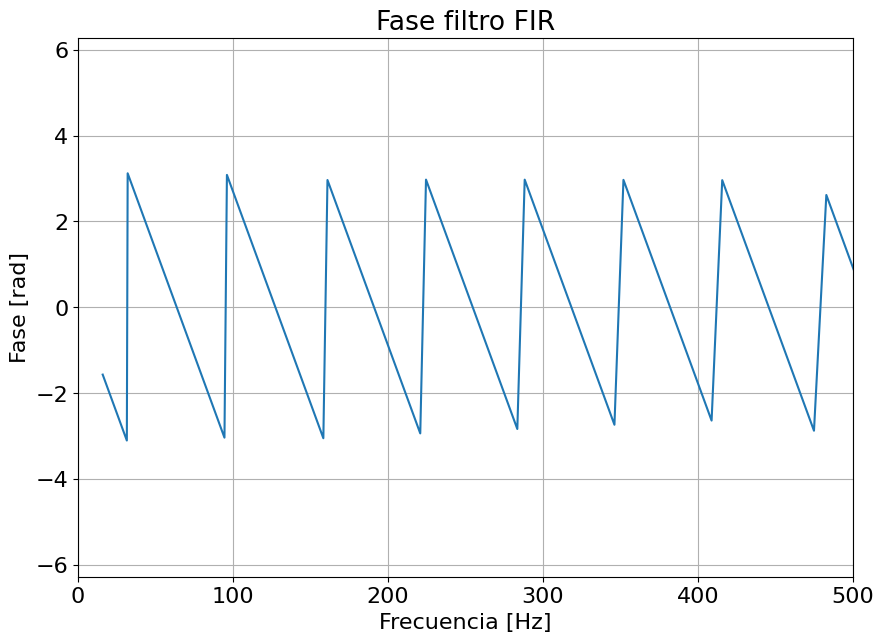

In [10]:
#Fase
fase = np.angle(hh_win)
plt.plot((w/np.pi * nyq_frec), fase)

plt.title('Fase filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, nyq_frec, -2*np.pi, 2*np.pi])

(0.0, 500.0, 0.0, 5000.0)

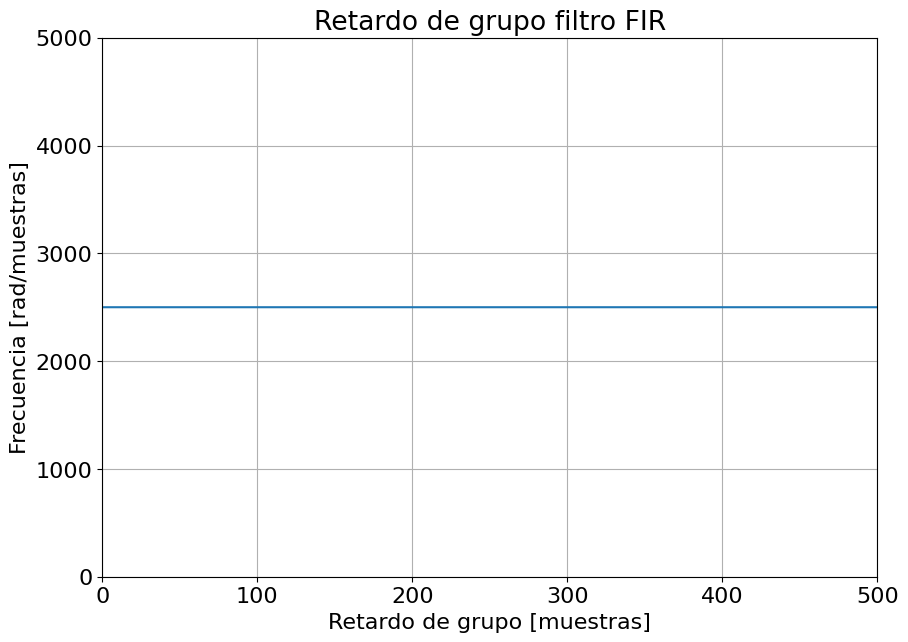

In [11]:
#Retardo de grupo
w, gd = sig.group_delay((num_win, den), w=2000, whole=False, fs=fs)

plt.plot(w, gd)
plt.title('Retardo de grupo filtro FIR')
plt.xlabel('Retardo de grupo [muestras]')
plt.ylabel('Frecuencia [rad/muestras]')
plt.grid()
plt.axis([0, nyq_frec, 0, 5000])

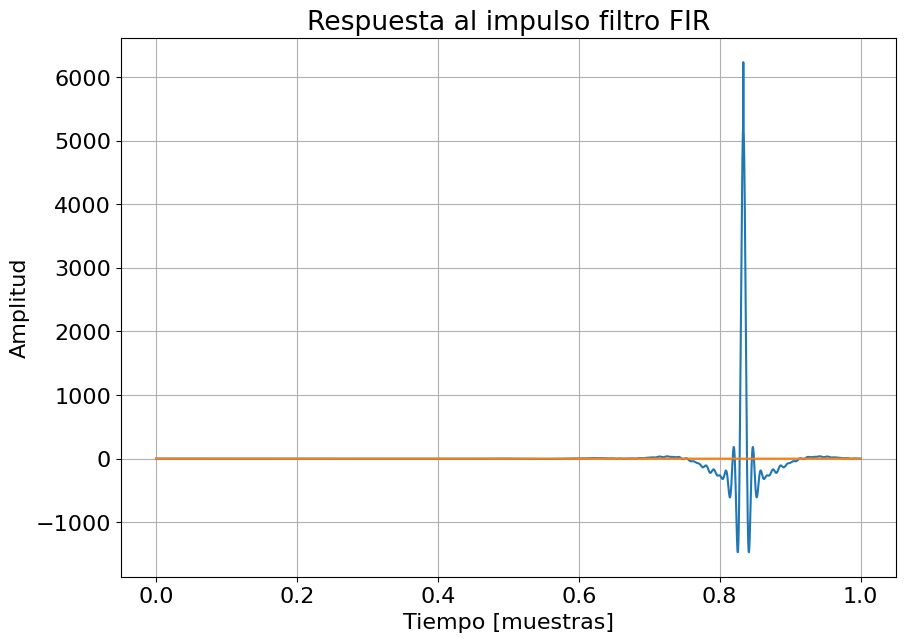

In [12]:
#Respuesta al impulso

imp = sig.unit_impulse(3000)

den = np.zeros(5001)
den[0] = 1

response = sig.lfilter(num_win, den, imp)

plt.plot(np.linspace(0, 1, 3000), response*(10**5))
plt.plot(np.linspace(0, 1, 3000), imp)

plt.title('Respuesta al impulso filtro FIR')
plt.xlabel('Tiempo [muestras]')
plt.ylabel('Amplitud')
plt.grid()

## <u> Parte 2: Implementación y uso  </u>  ##

Una vez diseñados los filtros procedemos a utilizarlos. Para ello SciPy dispone de dos implementaciones de la ecuación de diferencias, la tradicional mediante lfilter y la variante por SOS's mediante sosfilt. La primera puede usarse para filtros FIR de cualquier tamaño, e IIR de bajo orden (<= 3 secciones u orden 6), mientras que la segunda es obligatoria para filtros IIR de orden superior.

In [13]:
# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# -- FIR --
ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)

Ahora visualizamos los resultados, para ello se cuenta con diferentes regiones de interés (ROI's) para poder evaluar qué tan bien se comportan los filtros diseñados. Primero revisaremos zonas de alta contaminación para evaluar qué tan eficiente es el filtrado.

Recordar que cada filtro impone una demora a la señal filtrada, por lo tanto, dicha demora puede corregirse para cada filtro retrasando la señal de entrada o adelantando la señal de salida. Recuerde que como la señal ya fue registrada, una secuencia puede adelantarse.

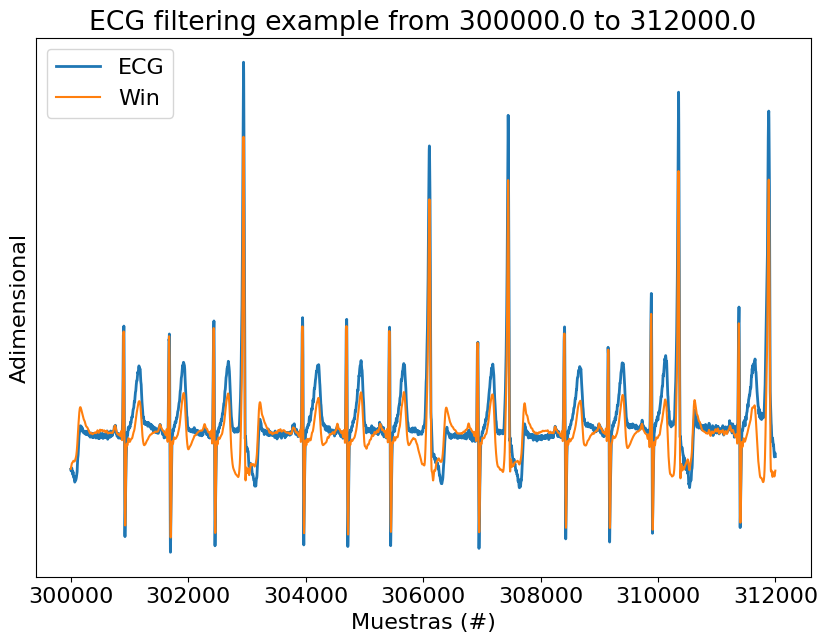

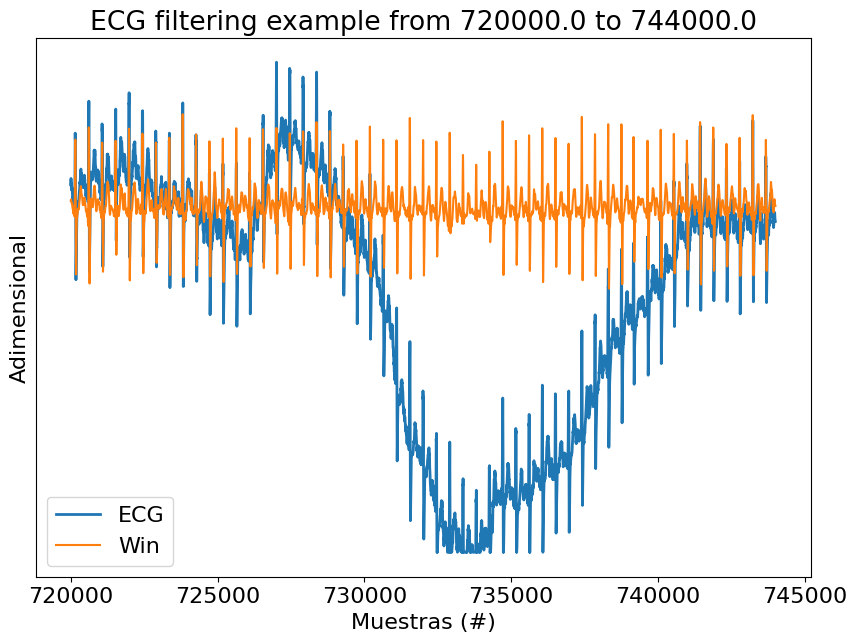

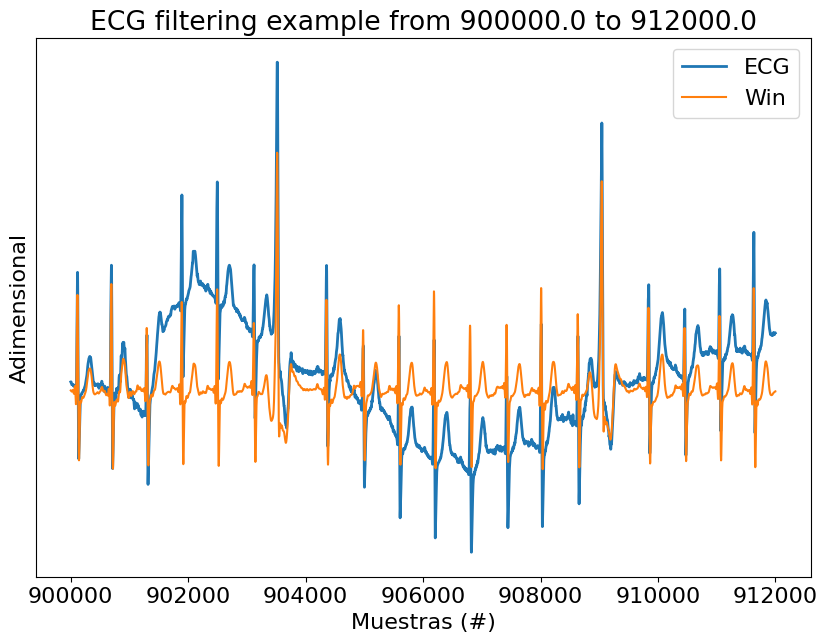

In [14]:
#Se calcula la demora para sincronizar las señales

demora = int(np.round(gd[250]))

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Al analizar el efecto del filtrado, observamos que la señal original de ECG (en azul) posee contaminación de baja frecuencia en algunas zonas del registro. Dicha contaminación probablemente se deba al aumento de la actividad física durante la prueba de esfuerzo. Como se observa, la mayor parte de las técnicas de filtrados es inocua cuando no hay contaminación de baja frecuencia, y remueve los movimientos de la línea de base correctamente.

Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos con baja contaminación, es decir qué tan inocuo es el filtro en su banda de paso. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico.

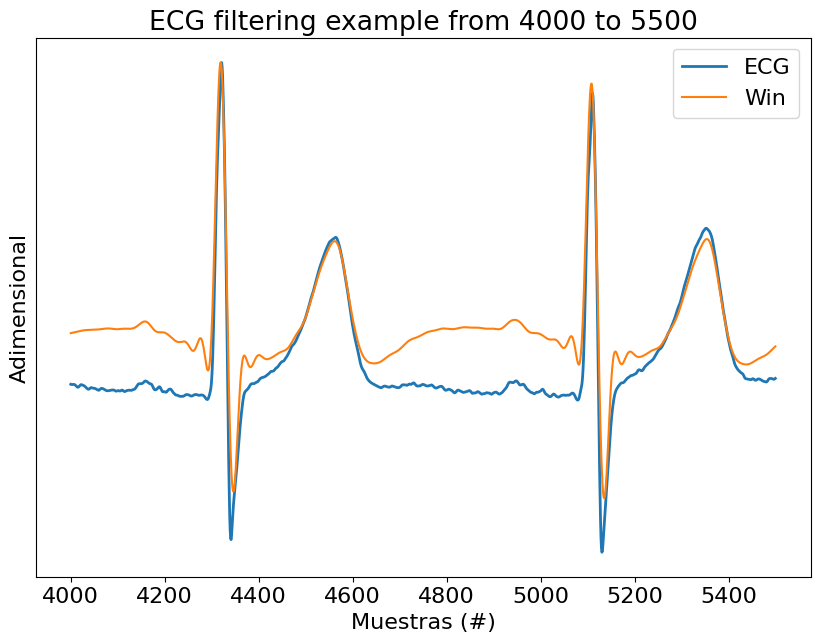

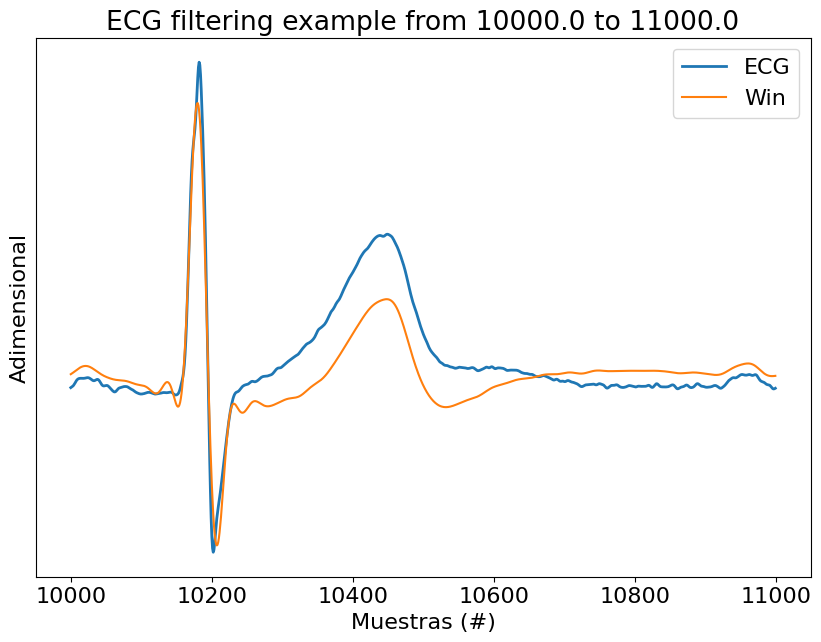

In [15]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Finalmente implementaremos los mismos filtros con una técnica diferente llamada filtrado bidireccional [scipy.signal.filtfilt](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html).

El filtrado bidireccional es una técnica sumamente conveniente al momento de filtrar digitalmente una señal, dado que evita por completo cualquier distorsión de fase. Esto afecta principalmente a los filtros IIR, donde las distorsiones pueden ser notorias. Sin embargo, los filtros FIR cuya respuesta al impulso sea simétrica (par o simpar), no producen distorsión de fase debido a que su fase es lineal.

En ambos casos, tanto para los IIR como para los FIR, simétricos o no, el resultado es una anulación completa de la respuesta de fase, obteniéndose así un filtro de fase cero. Recordemos que la transformada de Fourier de la inversión en tiempo es


$
\begin{equation}
x[−k] \leftrightarrow X∗(e^{jΩ}) \tag{7}
\end{equation}
$
Por lo tanto, vemos que la inversión en tiempo conlleva la negación de la respuesta de fase de una señal. Entonces utilizaremos una doble inversión temporal para cancelar los efectos de fase, y al mismo tiempo el resultado neto sobre la señal espejada dos veces será nulo
$
\begin{equation}
Y(e^{jΩ})=X(e^{jΩ})⋅T^∗(e^{jΩ})⋅T(e^{jΩ}) \tag{8}
\end{equation}
$
$
\begin{equation}
Y=X⋅|T|^2 \tag{9}
\end{equation}
$
(Se simplificó la notación para clarificar el resultado) Se observa como resultado de aplicar el método bidireccional un filtro equivalente al cuadrado del módulo y con aporte nulo de fase para todas las frecuencias. Esto equivale a haber atravesado dos veces por el mismo filtro, por lo tanto la atenuación será el doble que la del filtro original (y el ripple en banda también!) razón por lo cual debe modificarse la plantilla de diseño relajando a la mitad la atenuación, es decir exigiendo menos atenuación, pero duplicando la exigencia de ripple, es decir dividiendo por dos el ripple.

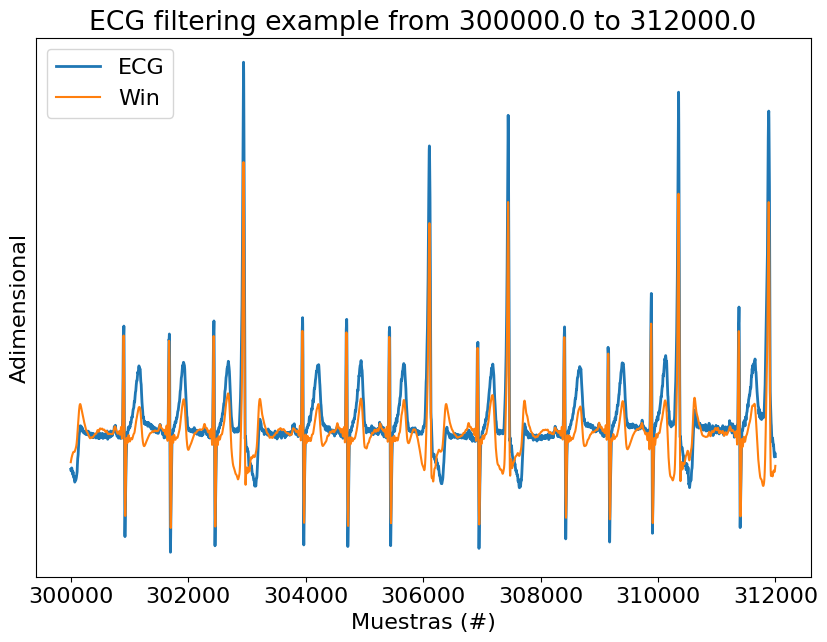

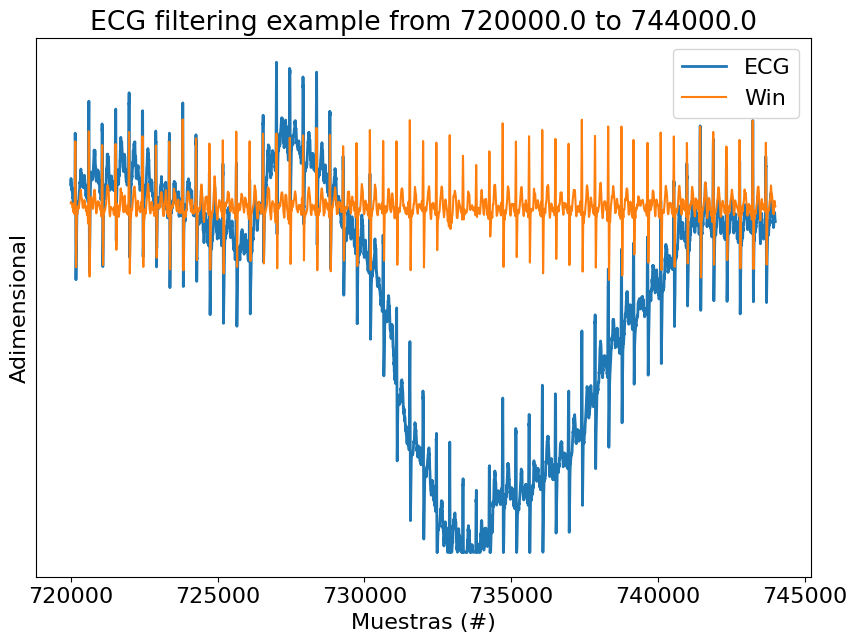

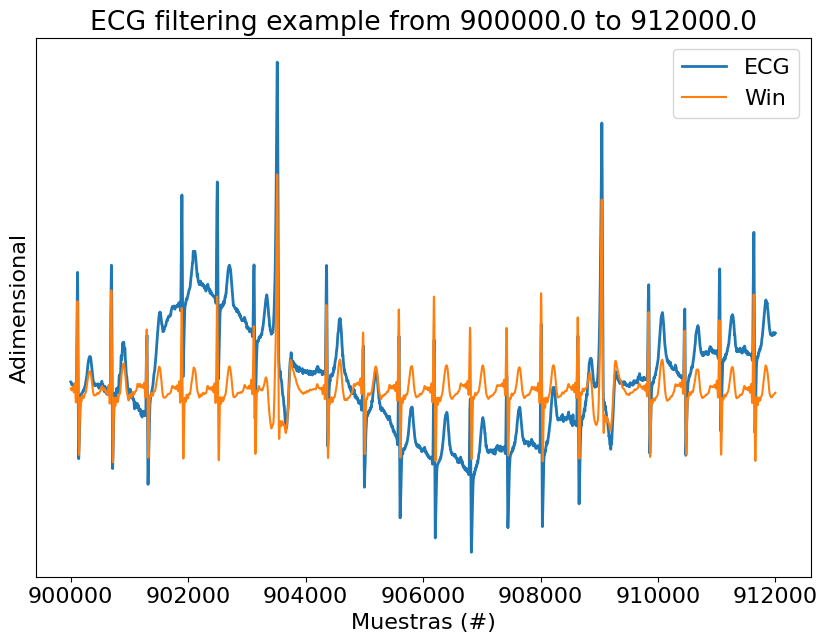

In [16]:
# Procedemos al filtrado
# ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Volvemos a revisar los detalles menos contaminados:

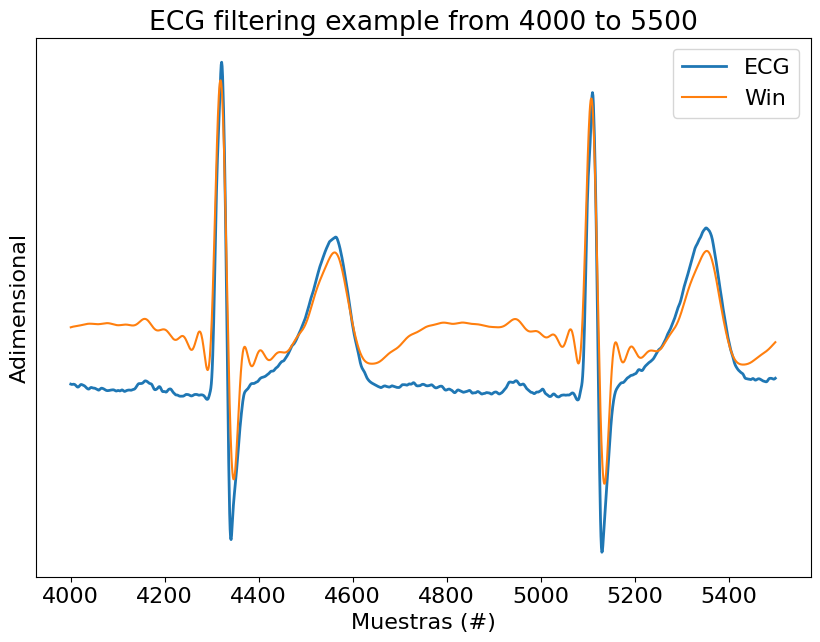

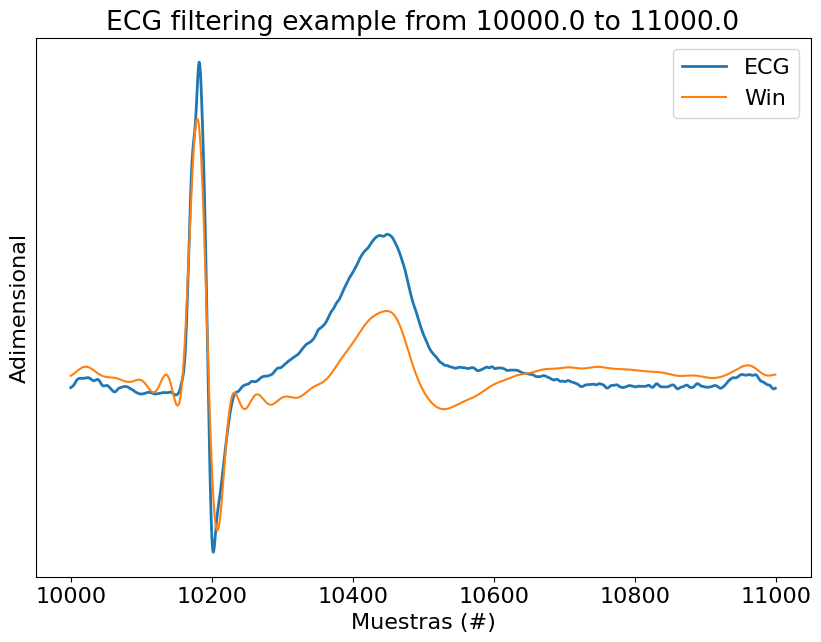

In [17]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Como se observa, la señal de ECG ha sido alterada en su morfología, a pesar de que la fase no pudo haber sido la responsable luego de haber usado el filtrado bidireccional. El complejo de ondas QRS, es decir las primeras deflecciones rápidas de mayor energía relacionadas con la compresión muscular, han sido claramente atenuadas, mientras que la onda T, la segunda onda positiva de mayor duración y relacionada con la relajación muscular, ha sido también atenuada. También se observan otros artefactos ocasionados por el filtrado lineal, como oscilaciones que no estaban presentes en el ECG original. Estas observaciones dan cuenta, que estos filtros no son adecuados para esta tarea y es necesario su rediseño teniendo en cuenta estos aspectos.

Quedan pendiente las siguientes cuestiones, en caso que los filtros no se hayan comportado de acuerdo a lo esperado:

1. ¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?
2. ¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?

Y en caso que los filtros hayan funcionado como esperaba, reflexione sobre cómo los utilizaría en una arquitectura digital como las usadas en las Informáticas o las Técnicas Digitales.

1. Uno de los motivos posibles es la plantilla del diseño que puede no ser muy precisa para la tarea en cuestión. Por otro lado, podría haber ruido en la banda de frecuencia de la señal estudiada.
2. Con lo simulado anteriormente se llega a la conclusión de que la fase no puede ser culpable de la distorsión sino que es la respuesta al impulso, provocada por el QRS.

Para la implementación en arquitecturas digitales se necesitaría usar la FFT (Fast Fourier Transform) para obtener la respuesta al impulso y, a través de algoritmos de convolución, poder ingresar señales para que sean afectadas por esta respuesta para obtener una salida filtrada.
